In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
sb.set()

from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import random

In [2]:
# Importing birth rate data
birthData = pd.read_csv("Datasets/Birth_Rate_clean.csv")
birthData.tail()

,Data Series,2022 Dec,2022 Nov,2022 Oct,2022 Sep,2022 Aug,2022 Jul,2022 Jun,2022 May,2022 Apr,...,1960 Oct,1960 Sep,1960 Aug,1960 Jul,1960 Jun,1960 May,1960 Apr,1960 Mar,1960 Feb,1960 Jan
10,Total Female Live-Births By Ethnic Group,1422,1452,1506,1539,1458,1426,1379,1420,1306,...,2754,2478,2583,2547,2451,2586,2388,2396,2166,2360
11,Malays,308,323,333,363,319,287,330,320,331,...,474,441,472,426,413,432,393,418,402,394
12,Chinese,825,797,856,869,799,831,748,831,705,...,2013,1754,1856,1848,1794,1910,1776,1756,1523,1701
13,Indians,158,182,161,163,150,173,155,142,154,...,218,243,200,218,210,196,179,178,192,227
14,Other Ethnic Groups,131,150,156,144,190,135,146,127,116,...,49,40,55,55,34,48,40,44,49,38


In [3]:
# Data cleaning
# Update index name
birthData = birthData.rename(columns = {'Data Series':'Date'})
birthData.set_index('Date',inplace=True)
birthData = birthData.rename(columns=lambda x: x.strip())
birthData.columns = pd.DatetimeIndex(birthData.columns).to_period('M')
# birthData.head()

# Switch rows and columns (Tranpose)
birthData = birthData.T
birthData = birthData.rename(columns=lambda x: x.strip())
birthData = birthData.sort_index()
birthData.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 756 entries, 1960-01 to 2022-12
Freq: M
Data columns (total 15 columns):
 #   Column                                    Non-Null Count  Dtype
---  ------                                    --------------  -----
 0   Total Live-Births By Ethnic Group         756 non-null    int64
 1   Malays                                    756 non-null    int64
 2   Chinese                                   756 non-null    int64
 3   Indians                                   756 non-null    int64
 4   Other Ethnic Groups                       756 non-null    int64
 5   Total Male Live-Births By Ethnic Group    756 non-null    int64
 6   Malays                                    756 non-null    int64
 7   Chinese                                   756 non-null    int64
 8   Indians                                   756 non-null    int64
 9   Other Ethnic Groups                       756 non-null    int64
 10  Total Female Live-Births By Ethnic Group  7

<AxesSubplot:>

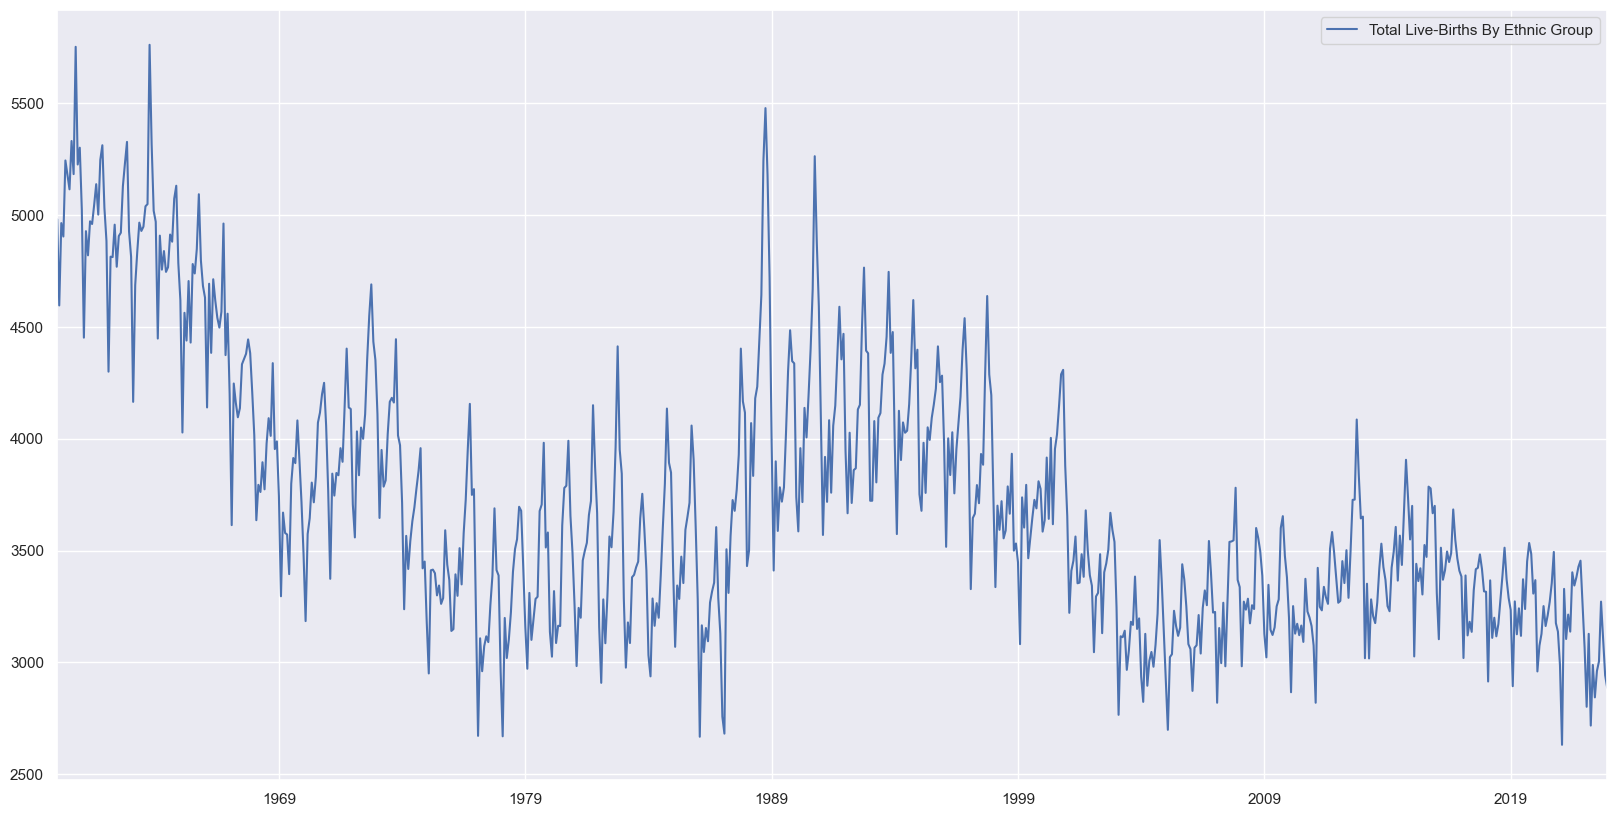

In [4]:
babies = pd.DataFrame(birthData['Total Live-Births By Ethnic Group'])

babies.head()
babies = babies.astype('int64')
babies.plot(figsize=(20, 10))

## Variable: Food Cost

- Standardized the date to `YYYY-MM` following the date format for the birth count dataset

In [5]:
# Variable: Food Costs
food = pd.read_csv('Datasets/FnB_Services_Index.csv', header = 0)
food = food.rename(columns = {'Data Series':'Date','Fast Food Outlets':'Fast Food','Cafes, Food Courts & Other Eating Places':'Others'})
birthData = birthData.rename(columns=lambda x: x.strip())
food['Date'] = pd.to_datetime(food['Date'])
food['Date'] = food['Date'].dt.strftime('%Y-%m')

food = food.set_index('Date')
food.index = pd.to_datetime(food.index).to_period('M')
# Set missing 'na' data to 0
food = food.fillna(0)
food.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 457 entries, 2023-01 to 1985-01
Freq: M
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Total                         457 non-null    float64
 1   Restaurants                   457 non-null    float64
 2   Fast Food                     457 non-null    float64
 3   Food Caterers                 457 non-null    float64
 4   Food Caterers (Extrapolated)  457 non-null    float64
 5   Others                        457 non-null    float64
dtypes: float64(6)
memory usage: 25.0 KB


- Missing data of `Food Caterers` before 2005 were extrapolated using the same trend as the `Total` variable
- Acceptable extrapolation as `Total` would be based on the other columns, meaning that the `Food Caterer` component of `Total` was only identified from 2005 onwards 
- Formula: Current Food Caterer = Previous Food Caterer*(Total of Current Year/Total of Previous Year)

<AxesSubplot:xlabel='Date'>

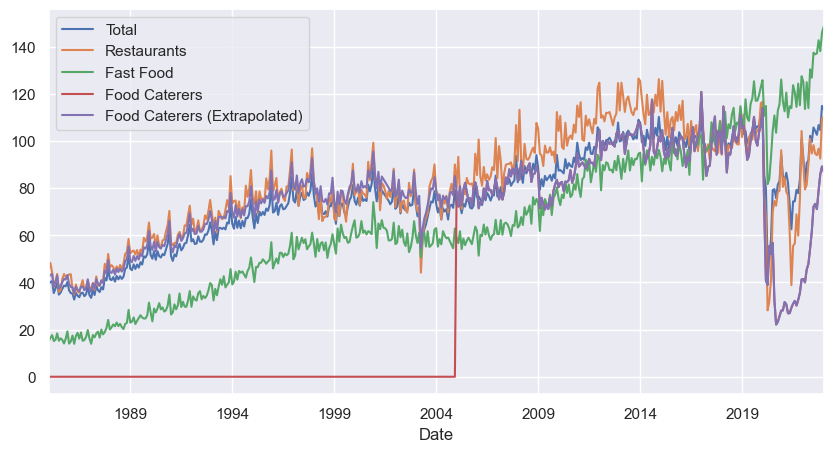

In [6]:
foodMerge = pd.concat([food['Total'], food['Restaurants'], food['Fast Food'], food['Food Caterers'], food['Food Caterers (Extrapolated)']], axis=1, join='inner')
foodMerge = foodMerge.loc[:,~foodMerge.columns.duplicated(keep='first')]
foodMerge.plot(figsize=(10, 5))

<AxesSubplot:>

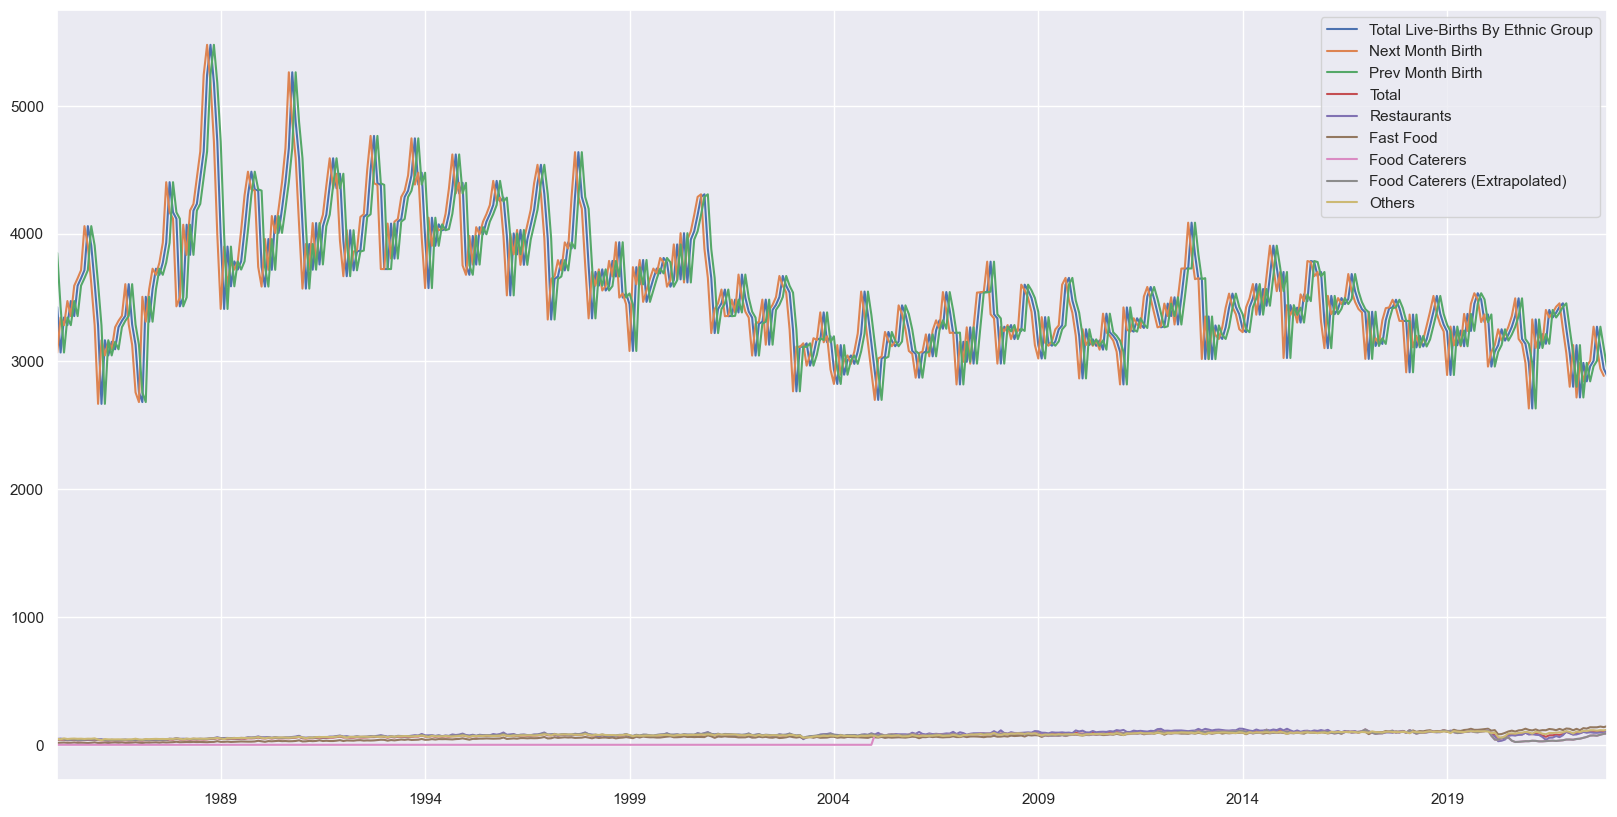

In [7]:
foodBaby = pd.DataFrame(birthData['Total Live-Births By Ethnic Group'])
foodBaby['Next Month Birth'] = foodBaby['Total Live-Births By Ethnic Group'].shift(-1)
foodBaby['Prev Month Birth'] = foodBaby['Total Live-Births By Ethnic Group'].shift(1)
foodTotal = foodBaby.join(food['Total'], how='inner')
foodRestaurant = foodBaby.join(food['Restaurants'], how='inner')
foodFastFood = foodBaby.join(food['Fast Food'], how='inner')
foodFoodCaterers = foodBaby.join(food['Food Caterers'], how='inner')
foodFoodCaterersEx = foodBaby.join(food['Food Caterers (Extrapolated)'], how='inner')
foodOthers = foodBaby.join(food['Others'], how='inner')
foodMerge = pd.concat([foodTotal, foodRestaurant, foodFastFood, foodFoodCaterers, foodFoodCaterersEx, foodOthers], axis=1, join='inner')
foodMerge = foodMerge.loc[:,~foodMerge.columns.duplicated(keep='first')]
foodMerge.plot(figsize=(20, 10))

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 456 entries, 1985-01 to 2022-12
Freq: M
Data columns (total 9 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Total Live-Births By Ethnic Group  456 non-null    int64  
 1   Next Month Birth                   455 non-null    float64
 2   Prev Month Birth                   456 non-null    float64
 3   Total                              456 non-null    float64
 4   Restaurants                        456 non-null    float64
 5   Fast Food                          456 non-null    float64
 6   Food Caterers                      456 non-null    float64
 7   Food Caterers (Extrapolated)       456 non-null    float64
 8   Others                             456 non-null    float64
dtypes: float64(8), int64(1)
memory usage: 51.8 KB


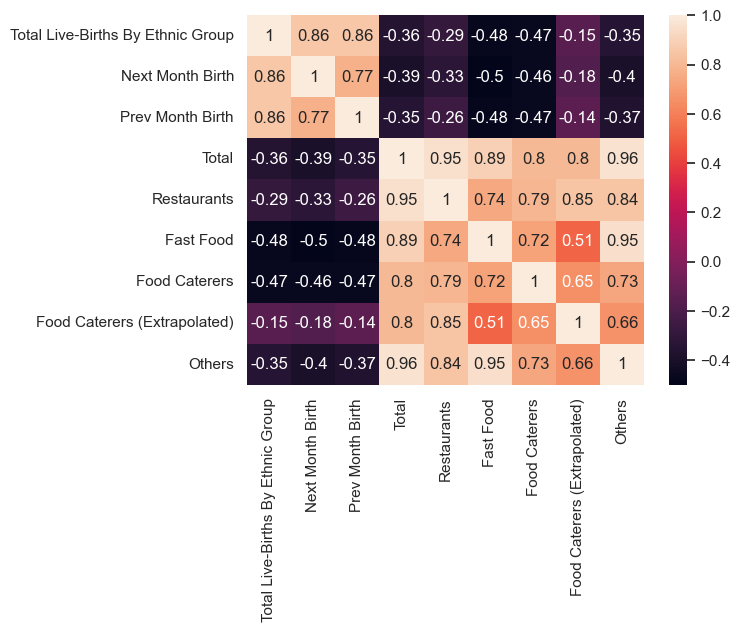

In [8]:
foodMerge.info()
foodMerge.corr()
corr_matrix = foodMerge.corr()
sb.heatmap(corr_matrix, annot=True)
plt.show()

## Analysis
- `Restaurants` does not have a good enough correlation, thus removed
- `Food Caterers (Extrapolated)` does not have good correlation, thus removed
- `Food Caterers` only has sufficient data points from 2005, thus using it as a factor might be inaccurate, thus removed

In [9]:
foodUpdate = pd.concat([foodTotal, foodFastFood, foodOthers], axis=1, join='inner')
foodUpdate = foodUpdate.loc[:,~foodUpdate.columns.duplicated(keep='first')]
foodUpdate.info()
foodUpdate.corr()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 456 entries, 1985-01 to 2022-12
Freq: M
Data columns (total 6 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Total Live-Births By Ethnic Group  456 non-null    int64  
 1   Next Month Birth                   455 non-null    float64
 2   Prev Month Birth                   456 non-null    float64
 3   Total                              456 non-null    float64
 4   Fast Food                          456 non-null    float64
 5   Others                             456 non-null    float64
dtypes: float64(5), int64(1)
memory usage: 41.1 KB


,Total Live-Births By Ethnic Group,Next Month Birth,Prev Month Birth,Total,Fast Food,Others
Total Live-Births By Ethnic Group,1.000000,0.857176,0.856346,-0.356590,-0.476055,-0.349138
Next Month Birth,0.857176,1.000000,0.773787,-0.394874,-0.499510,-0.396923
Prev Month Birth,0.856346,0.773787,1.000000,-0.351712,-0.479969,-0.370455
Total,-0.356590,-0.394874,-0.351712,1.000000,0.892406,0.959811
Fast Food,-0.476055,-0.499510,-0.479969,0.892406,1.000000,0.949052
Others,-0.349138,-0.396923,-0.370455,0.959811,0.949052,1.000000


## Classification: Random Forest vs Logistic Regression
- Goal: From the available variables this month, predict the rise/fall of the next month's birth rate
- Available Data:
    - Current/Prev Month Birth Count
    - Total/FastFood/Others
    
## Performance Evaluation Technique: K-Fold vs Leave-One-Out
- Leave-one-out too computational expensive, going for K-Fold instead
- Since dataset is small (About 300+ data points), use a smaller fold number (3)
- This gives about 100+ data points for each fold

## Classification Model Performance Metrics
- Accuracy:  Number of correct predictions
- Precision: Proportion of true positives out of all positive predictions
- Recall:    Proportion of true positives out of all actual positive cases
- F1 Score:  Harmonic mean of precision and recall

In [10]:
# Step 1: Create binary target variable
foodUpdate['Rise-Fall'] = (foodUpdate['Total Live-Births By Ethnic Group'] > foodUpdate['Next Month Birth']).astype(int)

In [11]:
resultsRf = []

for i in range(100):
    # Defining number of folds for cross-validation
    num_folds = 3
    
    # Defining random seed
    seed = random.randint(0, 100000)
       
    # Step 2: Combine features into single dataframe
    # Step 2.1: Predictors
    X = foodUpdate[['Total Live-Births By Ethnic Group', 'Prev Month Birth', 'Total', 'Fast Food','Others']]

    # Step 2.2: Response
    y = foodUpdate['Rise-Fall']
    
    # Step 3: Creating KFold
    kResRf = []
    kf = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

    # Step 4: Loop over folds
    for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
        # Step 4.1: Split data into training and test sets
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Step 4.2: Creating Random Forest and Logistic Regression Classifier
        rf = RandomForestClassifier(max_depth=10)
        
        # Step 4.3: Fit model to training data
        rf.fit(X_train, y_train)
        
        # Step 4.4: Make predictions on test data
        y_pred_rf = rf.predict(X_test)
        
        # Step 4.5: Evalute performance
        accuracy_rf = accuracy_score(y_test, y_pred_rf)
        precision_rf = precision_score(y_test, y_pred_rf)
        recall_rf = recall_score(y_test, y_pred_rf)
        f1_rf = f1_score(y_test, y_pred_rf)
        
        kResRf.append((fold, accuracy_rf, precision_rf, recall_rf, f1_rf))
        
    # Step 6: Compute the mean and standard deviation of the performance metrics across all folds
    acc_mean_rf, acc_std_rf = np.mean([r[1] for r in kResRf]), np.std([r[1] for r in kResRf])
    prec_mean_rf, prec_std_rf = np.mean([r[2] for r in kResRf]), np.std([r[2] for r in kResRf])
    rec_mean_rf, rec_std_rf = np.mean([r[3] for r in kResRf]), np.std([r[3] for r in kResRf])
    f1_mean_rf, f1_std_rf = np.mean([r[4] for r in kResRf]), np.std([r[4] for r in kResRf])
    
    resultsRf.append((seed, acc_mean_rf, acc_std_rf, prec_mean_rf, prec_std_rf, rec_mean_rf, rec_std_rf, f1_mean_rf, f1_std_rf))

# Sort results by F1 score in descending order
resultsRf.sort(key=lambda x: x[7], reverse=True)

In [12]:
resultsLr = []

for i in range(5):
    seed = resultsRf[i][0]
    kResLr = []
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        lr = LogisticRegression(max_iter=1000, solver='liblinear')
        lr.fit(X_train, y_train)
        y_pred_lr = lr.predict(X_test)
        
        accuracy_lr = accuracy_score(y_test, y_pred_lr)
        precision_lr = precision_score(y_test, y_pred_lr)
        recall_lr = recall_score(y_test, y_pred_lr)
        f1_lr = f1_score(y_test, y_pred_lr)
        kResLr.append((fold, accuracy_lr, precision_lr, recall_lr, f1_lr))
        
    acc_mean_lr, acc_std_lr = np.mean([r[1] for r in kResLr]), np.std([r[1] for r in kResLr])
    prec_mean_lr, prec_std_lr = np.mean([r[2] for r in kResLr]), np.std([r[2] for r in kResLr])
    rec_mean_lr, rec_std_lr = np.mean([r[3] for r in kResLr]), np.std([r[3] for r in kResLr])
    f1_mean_lr, f1_std_lr = np.mean([r[4] for r in kResLr]), np.std([r[4] for r in kResLr])   
    resultsLr.append((seed, acc_mean_lr, acc_std_lr, prec_mean_lr, prec_std_lr, rec_mean_lr, rec_std_lr, f1_mean_lr, f1_std_lr))

In [13]:
topResultsRf = resultsRf[:5]

for i in range(5):
    print('----------------------------------------------')
    print(f"Random state {topResultsRf[i][0]}:")
    print(f'Accuracy  = {topResultsRf[i][1]:.4f} +/- {topResultsRf[i][2]:.4f}  vs  {resultsLr[i][1]:.4f} +/- {resultsLr[i][2]:.4f}')
    print(f'Precision = {topResultsRf[i][3]:.4f} +/- {topResultsRf[i][4]:.4f}  vs  {resultsLr[i][3]:.4f} +/- {resultsLr[i][4]:.4f}')
    print(f'Recall    = {topResultsRf[i][5]:.4f} +/- {topResultsRf[i][6]:.4f}  vs  {resultsLr[i][5]:.4f} +/- {resultsLr[i][6]:.4f}')
    print(f'F1 score  = {topResultsRf[i][7]:.4f} +/- {topResultsRf[i][8]:.4f}  vs  {resultsLr[i][7]:.4f} +/- {resultsLr[i][8]:.4f}')
print('----------------------------------------------')

----------------------------------------------
Random state 29055:
Accuracy  = 0.6732 +/- 0.0551  vs  0.5965 +/- 0.0434
Precision = 0.6593 +/- 0.0890  vs  0.5821 +/- 0.0609
Recall    = 0.6957 +/- 0.0265  vs  0.5844 +/- 0.0242
F1 score  = 0.6725 +/- 0.0447  vs  0.5823 +/- 0.0400
----------------------------------------------
Random state 76847:
Accuracy  = 0.6820 +/- 0.0276  vs  0.5965 +/- 0.0434
Precision = 0.6720 +/- 0.0333  vs  0.5821 +/- 0.0609
Recall    = 0.6715 +/- 0.0746  vs  0.5844 +/- 0.0242
F1 score  = 0.6680 +/- 0.0313  vs  0.5823 +/- 0.0400
----------------------------------------------
Random state 23646:
Accuracy  = 0.6623 +/- 0.0328  vs  0.5965 +/- 0.0434
Precision = 0.6378 +/- 0.0735  vs  0.5821 +/- 0.0609
Recall    = 0.6987 +/- 0.0422  vs  0.5844 +/- 0.0242
F1 score  = 0.6635 +/- 0.0435  vs  0.5823 +/- 0.0400
----------------------------------------------
Random state 68067:
Accuracy  = 0.6798 +/- 0.0189  vs  0.5965 +/- 0.0434
Precision = 0.6713 +/- 0.0255  vs  0.5821 +

In [14]:
print(f'Average Accuracy:  {sum([i[1] for i in topResultsRf])/5:.4f}  vs  {sum([i[1] for i in resultsLr])/5:.4f}')
print(f'Average Precision: {sum([i[3] for i in topResultsRf])/5:.4f}  vs  {sum([i[3] for i in resultsLr])/5:.4f}')
print(f'Average Recall:    {sum([i[5] for i in topResultsRf])/5:.4f}  vs  {sum([i[5] for i in resultsLr])/5:.4f}')
print(f'Average F1 Score:  {sum([i[7] for i in topResultsRf])/5:.4f}  vs  {sum([i[7] for i in resultsLr])/5:.4f}')

Average Accuracy:  0.6732  vs  0.5965
Average Precision: 0.6579  vs  0.5821
Average Recall:    0.6815  vs  0.5844
Average F1 Score:  0.6658  vs  0.5823


## Final Verdict on Models
The logistic regression has been constanly doing worse than the random forest, despite using the same seed and after testing with different number of variables

Conclusion: Random forest is the better model in this case

In [15]:
resultsRf2 = []

for i in range(5):
    seed = resultsRf[i][0]
       
    # Step 2: Combine features into single dataframe
    # Step 2.1: Predictors
    X = foodUpdate[['Total Live-Births By Ethnic Group', 'Prev Month Birth', 'Total', 'Fast Food']]

    # Step 2.2: Response
    y = foodUpdate['Rise-Fall']
    
    # Step 3: Creating KFold
    kResRf = []
    kf = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

    # Step 4: Loop over folds
    for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
        # Step 4.1: Split data into training and test sets
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Step 4.2: Creating Random Forest and Logistic Regression Classifier
        rf = RandomForestClassifier(max_depth=10)
        
        # Step 4.3: Fit model to training data
        rf.fit(X_train, y_train)
        
        # Step 4.4: Make predictions on test data
        y_pred_rf = rf.predict(X_test)
        
        # Step 4.5: Evalute performance
        accuracy_rf = accuracy_score(y_test, y_pred_rf)
        precision_rf = precision_score(y_test, y_pred_rf)
        recall_rf = recall_score(y_test, y_pred_rf)
        f1_rf = f1_score(y_test, y_pred_rf)
        
        kResRf.append((fold, accuracy_rf, precision_rf, recall_rf, f1_rf))
        
    # Step 6: Compute the mean and standard deviation of the performance metrics across all folds
    acc_mean_rf, acc_std_rf = np.mean([r[1] for r in kResRf]), np.std([r[1] for r in kResRf])
    prec_mean_rf, prec_std_rf = np.mean([r[2] for r in kResRf]), np.std([r[2] for r in kResRf])
    rec_mean_rf, rec_std_rf = np.mean([r[3] for r in kResRf]), np.std([r[3] for r in kResRf])
    f1_mean_rf, f1_std_rf = np.mean([r[4] for r in kResRf]), np.std([r[4] for r in kResRf])
    
    resultsRf2.append((seed, acc_mean_rf, acc_std_rf, prec_mean_rf, prec_std_rf, rec_mean_rf, rec_std_rf, f1_mean_rf, f1_std_rf))

In [16]:
resultsRf3 = []

for i in range(5):
    seed = resultsRf[i][0]
       
    # Step 2: Combine features into single dataframe
    # Step 2.1: Predictors
    X = foodUpdate[['Total Live-Births By Ethnic Group', 'Prev Month Birth', 'Total','Others']]

    # Step 2.2: Response
    y = foodUpdate['Rise-Fall']
    
    # Step 3: Creating KFold
    kResRf = []
    kf = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

    # Step 4: Loop over folds
    for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
        # Step 4.1: Split data into training and test sets
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Step 4.2: Creating Random Forest and Logistic Regression Classifier
        rf = RandomForestClassifier(max_depth=10)
        
        # Step 4.3: Fit model to training data
        rf.fit(X_train, y_train)
        
        # Step 4.4: Make predictions on test data
        y_pred_rf = rf.predict(X_test)
        
        # Step 4.5: Evalute performance
        accuracy_rf = accuracy_score(y_test, y_pred_rf)
        precision_rf = precision_score(y_test, y_pred_rf)
        recall_rf = recall_score(y_test, y_pred_rf)
        f1_rf = f1_score(y_test, y_pred_rf)
        
        kResRf.append((fold, accuracy_rf, precision_rf, recall_rf, f1_rf))
        
    # Step 6: Compute the mean and standard deviation of the performance metrics across all folds
    acc_mean_rf, acc_std_rf = np.mean([r[1] for r in kResRf]), np.std([r[1] for r in kResRf])
    prec_mean_rf, prec_std_rf = np.mean([r[2] for r in kResRf]), np.std([r[2] for r in kResRf])
    rec_mean_rf, rec_std_rf = np.mean([r[3] for r in kResRf]), np.std([r[3] for r in kResRf])
    f1_mean_rf, f1_std_rf = np.mean([r[4] for r in kResRf]), np.std([r[4] for r in kResRf])
    
    resultsRf3.append((seed, acc_mean_rf, acc_std_rf, prec_mean_rf, prec_std_rf, rec_mean_rf, rec_std_rf, f1_mean_rf, f1_std_rf))

In [17]:
resultsRf4 = []

for i in range(5):
    seed = resultsRf[i][0]
       
    # Step 2: Combine features into single dataframe
    # Step 2.1: Predictors
    X = foodUpdate[['Total Live-Births By Ethnic Group', 'Prev Month Birth', 'Fast Food','Others']]

    # Step 2.2: Response
    y = foodUpdate['Rise-Fall']
    
    # Step 3: Creating KFold
    kResRf = []
    kf = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

    # Step 4: Loop over folds
    for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
        # Step 4.1: Split data into training and test sets
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Step 4.2: Creating Random Forest and Logistic Regression Classifier
        rf = RandomForestClassifier(max_depth=10)
        
        # Step 4.3: Fit model to training data
        rf.fit(X_train, y_train)
        
        # Step 4.4: Make predictions on test data
        y_pred_rf = rf.predict(X_test)
        
        # Step 4.5: Evalute performance
        accuracy_rf = accuracy_score(y_test, y_pred_rf)
        precision_rf = precision_score(y_test, y_pred_rf)
        recall_rf = recall_score(y_test, y_pred_rf)
        f1_rf = f1_score(y_test, y_pred_rf)
        
        kResRf.append((fold, accuracy_rf, precision_rf, recall_rf, f1_rf))
        
    # Step 6: Compute the mean and standard deviation of the performance metrics across all folds
    acc_mean_rf, acc_std_rf = np.mean([r[1] for r in kResRf]), np.std([r[1] for r in kResRf])
    prec_mean_rf, prec_std_rf = np.mean([r[2] for r in kResRf]), np.std([r[2] for r in kResRf])
    rec_mean_rf, rec_std_rf = np.mean([r[3] for r in kResRf]), np.std([r[3] for r in kResRf])
    f1_mean_rf, f1_std_rf = np.mean([r[4] for r in kResRf]), np.std([r[4] for r in kResRf])
    
    resultsRf4.append((seed, acc_mean_rf, acc_std_rf, prec_mean_rf, prec_std_rf, rec_mean_rf, rec_std_rf, f1_mean_rf, f1_std_rf))

In [18]:
print(f'Average Accuracy:  {sum([i[1] for i in topResultsRf])/5:.4f}  \
      vs  {sum([i[1] for i in resultsRf2])/5:.4f} \
      vs  {sum([i[1] for i in resultsRf3])/5:.4f} \
      vs  {sum([i[1] for i in resultsRf4])/5:.4f}')
print(f'Average Precision: {sum([i[3] for i in topResultsRf])/5:.4f}  \
      vs  {sum([i[3] for i in resultsRf2])/5:.4f} \
      vs  {sum([i[3] for i in resultsRf3])/5:.4f} \
      vs  {sum([i[3] for i in resultsRf4])/5:.4f}')
print(f'Average Recall:    {sum([i[5] for i in topResultsRf])/5:.4f}  \
      vs  {sum([i[5] for i in resultsRf2])/5:.4f} \
      vs  {sum([i[5] for i in resultsRf3])/5:.4f} \
      vs  {sum([i[5] for i in resultsRf4])/5:.4f}')
print(f'Average F1 Score:  {sum([i[7] for i in topResultsRf])/5:.4f}  \
      vs  {sum([i[7] for i in resultsRf2])/5:.4f} \
      vs  {sum([i[7] for i in resultsRf3])/5:.4f} \
      vs  {sum([i[7] for i in resultsRf4])/5:.4f}')

Average Accuracy:  0.6732        vs  0.6689       vs  0.6566       vs  0.6719
Average Precision: 0.6579        vs  0.6529       vs  0.6407       vs  0.6547
Average Recall:    0.6815        vs  0.6715       vs  0.6585       vs  0.6814
Average F1 Score:  0.6658        vs  0.6586       vs  0.6469       vs  0.6651


## Accuracy
1. All
2. Total and Fast Food
3. Total and Others
4. Fast Food and Others

## Precision
1. All
2. Total and Fast Food
3. Total and Others
4. Fast Food and Others

## Recall
1. All
2. Total and Fast Food
3. Total and Others
4. Fast Food and Others

## F1 Score
1. All
2. Total and Fast Food
3. Total and Others
4. Fast Food and Others

## Final Verdict on Variables
Overall, keeping all variables gives the best model

As for the other 3
- Keeping the total as a factor with another of its component yields lower correlation
- Having the components by themselves yield higher correlation

Conclusion: Keep `Total` and all of its components `Fast Food` and `Others`

Food costs might not be a strong factor to use to predict birth rate given its lower correlation of 0.66